# Quantifying Mass Transfer between M31 and MW by means of the Jacobi Radius and Hernquist Profiles

The objective of this assignment is to discover which particles composing M31 and MW may transfer between each other during close encounters. We can do so by first calculating the Jacobi Radius for a given galaxy, and listing particles belonging to the galaxy that end up outside of the Jacobi radius. From there, we can further check if these particles undergo mass transfer by calculating their kinetic energy, and their analytic gravitational potential energy based on their Hernquist profile. This is assuming that the Hernquist profile still maintains a reasonable shape during these close encounters, so we will also have to calculate Hernquist profiles at snapnumbers of importance. 

In [35]:
#first things first, we need the relevant software that calculates the jacobi radius of a galaxy, as well as other software capable of reading in galaxy info

#we will also need our Hernquist profile code

#to visualize the types of particles that are prone to mass transfer, we will want a modified version of lab 7, where we can draw a sphere with radius r = r_jacobi

# import modules
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from GalaxyMass import ComponentMass
from MassProfile import mEncPlot



Jacobi radius: $R_j = r  \bigg( \frac{M_{sat}}{2 M_{host}(<r)} \bigg)^{1/3}$

assumptions: satellite is on circular orbit around an isothermal sphere. These are very big assumptions for particles that may not be following circular orbits around interacting galaxies that may not be isothermal spheres, but it does provide a ballpark estimate

For the Milky way, $M_{MW}(<r) = M_{halo} (r) + M_{disk} + M_{bulge}$, $M_{sat} = M_{31\ tot}$, and $r = R_{COM}$ between M31 and MW. Vice versa for M31's Jacobi radius. By the Hernquist profile assumption, $M_{halo}(r) = \frac{M_{halo\ tot} r^2}{(a+r)^2}$

In [80]:
#find Hernquist Dark Matter (DM) mass
def hernquist_mass(r, a = 60*u.kpc, m_halo = 1.975):
    """
    Defines the Hernquist 1990 mass profile
    Inputs:
        r: galactocentric distance in kpc (astropy)
        a: scale radius of Hernquist profile in kpc (astropy)
        m_halo: total halo mass in 10^12 Msun (float)

    output: 
        mass: astropy quantity
            total mass within the given r in Msun
    """
    mass = m_halo * 1e12 * r**2/(a+r)**2*u.Msun #Hernquist mass
    return mass

#find host mass
def find_host_mass(r,a, Mhalo, Mdisk, Mbulge):
    ''' 
    finds total host mass by summing enclosed Hernquist mass, disk mass, and bulge mass
    inputs:
        r: float, isothermal radius marking the boundary where we include host dark matter, in kpc. 
            It's possible that this should be the separation distance between MW and M31
        a: float, scale factor of host galaxy for the analytic Hernquist profile, in kpc
        Mhalo: float, total halo mass of host galaxy, in units of 10^12Msun
        Mdisk: total disk mass of host galaxy 10^12Msun
        Mbulge: total bulge mass of host galaxy in 10^12Msun
    outputs:
        tot_mass: float, total mass of the host galaxy for the Jacobi radius calculation (in 10^12 Msun)
    '''
    DM_mass = Mhalo * r**2 / (a+r)**2 #uses Hernquist mass equation, keeping in units of 10^12 Msun
    tot_mass = DM_mass + Mdisk + Mbulge
    return tot_mass



#compute the jacobi radius
def Jacobi_radius(Msat, Mhost, r):
    ''' 
    computes the jacobi radius for a galaxy based on the equation R_j = r(M_sat/(2Mhost))^(1/3). 
    As long as Msat and Mhost are in the same units, the units don't matter

    inputs:
        Msat: float, mass of the satellite in arbitrary units. Using total satellite mass 
        (including dark matter which may need to change)
        Mhost: float, mass of host galaxy, including complete disk mass, bulge mass, and dark matter up to 
        the isothermal sphere radius (or center of mass separation). In same arbitrary units as Msat
        r: float, center of mass separation between MW and M31 in kpc

    outputs:
        r_jacobi: float, jacobi radius of the satellite galaxy, beyond which particles may be susceptible to mass loss
    '''
    r_jacobi = r * (Msat / (2*Mhost))**(1/3)
    return r_jacobi


#we need the center of mass separations between MW and M31, which we calculated in HW6
#we stored these values in a file for the 800 snapshots
def RCOM_separation(gal1file, gal2file, time):
    '''
    finds the center of mass separation between MW and M31 at any given time, 
    based on our orbit separation calculation in HW6. A better method is to call the COM class directly
    which I will implement later

    inputs:
        gal1file: str, filename of one galaxy's center of mass evolution over time
        gal2file: str, filename of the other galaxy's center of mass evolution over time
        time: float, time at which we want to calculate the COM position separation, in units of Myr
    outputs:
        separation: float, the separation distance between the two galaxies at the time specified, in kpc
    '''
    g1orbit_data = np.genfromtxt(gal1file,dtype=None,names=True,skip_header=0)
    g2orbit_data = np.genfromtxt(gal2file,dtype=None,names=True,skip_header=0)
    times = g1orbit_data['t']
    index = np.where(abs(times-(time/1000)) < 0.001) #because of rounding, these numbers should be at least this close
    #time is divided by 1000 because these files have time in units of Gyr, but the txt files have time in Myr
    separation = np.sqrt((g1orbit_data['x'][index] - g2orbit_data['x'][index])**2 + 
                         (g1orbit_data['y'][index] - g2orbit_data['y'][index])**2 + 
                         (g1orbit_data['z'][index] - g2orbit_data['z'][index])**2) #distance formula
    return separation



MWtime, MWtotal, MWdata = Read('MW_410.txt') #find data for MW at this snapnumber
M31time, M31total, M31data = Read('M31_410.txt') #find data for M31 at this snapnumber

MW_halomass = ComponentMass('MW_410.txt', 1) #recall, units of 10^12 Msun
MW_diskmass = ComponentMass('MW_410.txt', 2) #recall, units of 10^12 Msun
MW_bulgemass = ComponentMass('MW_410.txt', 3) #recall, units of 10^12 Msun
MW_isotherm_rad = 50 #kpc, this will likely have to change
MW_scale_factor = 60 #kpc, this will certainly change

#host mass based on above parameters
MW_hostmass = find_host_mass(MW_isotherm_rad, MW_scale_factor, MW_halomass, MW_diskmass, MW_bulgemass)

#satellite mass, using every mass component completely
M31_satmass = ComponentMass('M31_410.txt', 1) + ComponentMass('M31_410.txt', 2) + ComponentMass('M31_410.txt', 3) #recall, units of 10^12 Msun

M31_MW_separation = RCOM_separation('OrbitMW_0_800.txt', 'OrbitM31_0_800.txt', MWtime.value)
print(M31_MW_separation)

M31_Jacobi_rad = Jacobi_radius(M31_satmass, MW_hostmass, M31_MW_separation)

#print(M31_Jacobi_rad) 
'''
this represents the minimum radius around M31 (the satellite in this case)
for matter to remain bound to M31. Anything beyond this radius may possibly drift to the host (MW)
or drift away to infinity
'''
'''
def scatterplot_galaxy(filename):
    time, total, data = Read(filename)
    xs = data['x']
    ys = data['y']
    zs = data['z']
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs,ys,zs)
%matplotlib widget
scatterplot_galaxy('M31_270.txt')
'''
#find the Hernquist potential for dark matter and bulge components, and the Miyamoto-Nagai potential for disk components

#let's try including all host matter up to the center of mass distance, instead of any isothermal sphere approximation
snap400_MW_scalefactor = 70
MW_hostmass = find_host_mass(M31_MW_separation, snap400_MW_scalefactor, MW_halomass, MW_diskmass, MW_bulgemass)
print(Jacobi_radius(M31_satmass, MW_hostmass, M31_MW_separation))
new_jacobi_rad = Jacobi_radius(M31_satmass, MW_hostmass, M31_MW_separation)


#time 300 M31 Jacobi radius is 148.55038516 kpc



[7.89798075]
[16.8907561]


Now let's look at M31 face on at this timestamp, and project a circle with the jacobi radius on top.
we will need some Lab7 software for this.

In [81]:
# Compute COM of M31 using disk particles
COMD_M31 = CenterOfMass("M31_410.txt",2)
COMP_M31 = COMD_M31.COM_P(0.1)
COMV_M31 = COMD_M31.COM_V(COMP_M31[0],COMP_M31[1],COMP_M31[2])
# Determine positions of disk particles relative to COM 
xD_M31 = COMD_M31.x - COMP_M31[0].value 
yD_M31 = COMD_M31.y - COMP_M31[1].value 
zD_M31 = COMD_M31.z - COMP_M31[2].value 

# total magnitude
rtot = np.sqrt(xD_M31**2 + yD_M31**2 + zD_M31**2)

# Determine velocities of disk particles relatiev to COM motion
vxD_M31 = COMD_M31.vx - COMV_M31[0].value 
vyD_M31 = COMD_M31.vy - COMV_M31[1].value 
vzD_M31 = COMD_M31.vz - COMV_M31[2].value 

# total velocity 
vtot_M31 = np.sqrt(vxD_M31**2 + vyD_M31**2 + vzD_M31**2)

# Vectors for r and v 
r_M31 = np.array([xD_M31,yD_M31,zD_M31]).T # transposed 
v_M31 = np.array([vxD_M31,vyD_M31,vzD_M31]).T

In [71]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [72]:
def get_disk_info(filename):
    '''
    This function creates the components of a galaxy's disk particles relative to the center of mass, 
    and velocity components relative to the center of mass. This is useful if we want to rotate the viewing frame to 
    be edge on. 

    inputs:
        filename: string
            -galaxy txt file we want to find the radius and velocity components of
    outputs:
        r: numpy array of x,y,z values of the disk particles
        v: numpy array of vx,vy,vz values of the disk particles
    '''
    COMD = CenterOfMass(filename,2)
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    return r, v

def get_DM_info(filename):
    '''
    This function creates the components of a galaxy's disk particles relative to the center of mass, 
    and velocity components relative to the center of mass. This is useful if we want to rotate the viewing frame to 
    be edge on. 

    inputs:
        filename: string
            -galaxy txt file we want to find the radius and velocity components of
    outputs:
        r: numpy array of x,y,z values of the disk particles
        v: numpy array of vx,vy,vz values of the disk particles
    '''
    COMD = CenterOfMass(filename,1)
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    return r, v

In [40]:
'''
# Rotated M31 Disk - FACE ON
# ADD HERE
# compute the rotated velocity vectors
r_M31, v_M31 = get_disk_info('M31_270.txt')
rn_M31, vn_M31 = RotateFrame(r_M31, v_M31)
# M31 Disk Density 
fig, ax= plt.subplots(figsize=(10, 10))
plt.hist2d(r_M31[:,0], r_M31[:,2], bins = 150, norm = LogNorm(), cmap = 'viridis')
# plot the particle density for M31 
# ADD HERE
#density_contour(r[:,0], r[:,2], 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])

plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# ADD HERE

# Add axis labels
plt.xlabel('  ', fontsize=22)
plt.ylabel('  ', fontsize=22)

#set axis limits
plt.ylim(-80,80)
plt.xlim(-80,80)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.show()
# Save to a file 
#plt.savefig('Lab7_FaceOn_Density.png')
'''

"\n# Rotated M31 Disk - FACE ON\n# ADD HERE\n# compute the rotated velocity vectors\nr_M31, v_M31 = get_disk_info('M31_270.txt')\nrn_M31, vn_M31 = RotateFrame(r_M31, v_M31)\n# M31 Disk Density \nfig, ax= plt.subplots(figsize=(10, 10))\nplt.hist2d(r_M31[:,0], r_M31[:,2], bins = 150, norm = LogNorm(), cmap = 'viridis')\n# plot the particle density for M31 \n# ADD HERE\n#density_contour(r[:,0], r[:,2], 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])\n\nplt.colorbar()\n\n# make the contour plot\n# x pos, y pos, contour res, contour res, axis, colors for contours.\n# ADD HERE\n\n# Add axis labels\nplt.xlabel('  ', fontsize=22)\nplt.ylabel('  ', fontsize=22)\n\n#set axis limits\nplt.ylim(-80,80)\nplt.xlim(-80,80)\n\n#adjust tick label font size\nlabel_size = 22\nmatplotlib.rcParams['xtick.labelsize'] = label_size \nmatplotlib.rcParams['ytick.labelsize'] = label_size\nplt.show()\n# Save to a file \n#plt.savefig('Lab7_FaceOn_Density.png')\n"

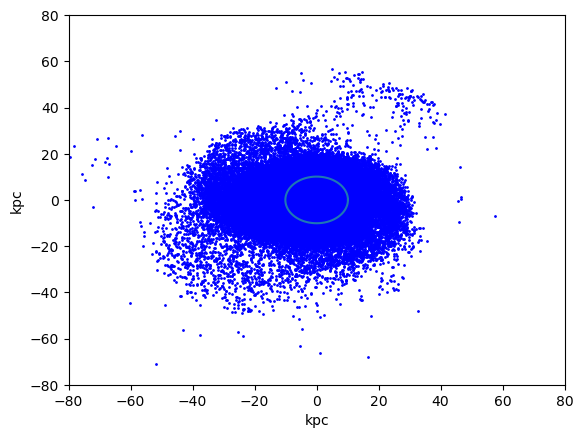

In [82]:
r_M31, v_M31 = get_disk_info('M31_410.txt')
rn_M31, vn_M31 = RotateFrame(r_M31, v_M31)
plt.scatter(r_M31[:,0], r_M31[:,2], s = 1, c = 'blue')
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
 
radius = M31_Jacobi_rad
 
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.ylim(-80,80)
plt.xlim(-80,80)
plt.plot(x,y)
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.show()

from a cursory glance, it looks like pretty much every particle is inside the jacobi radius. 
Let's see if this is really the case

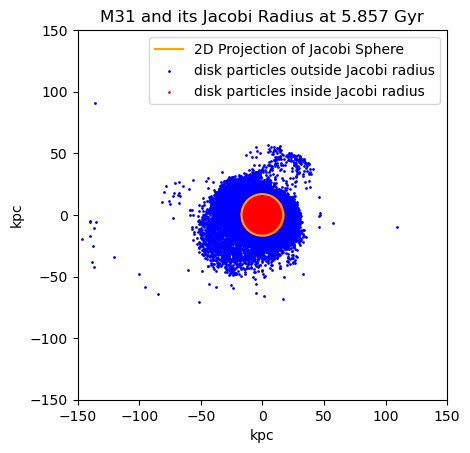

marked particle radii are [19.02065028 31.23169853 29.9703183  ... 56.29301645 51.69857019
 21.946113  ] kpc which is greater than [16.8907561] kpc


In [83]:
def find_outside_particles(r_j, xp,yp,zp, xcom, ycom, zcom):
    ''' 
    creates an array of particles with radii greater than the Jacobi radius, where the radius is 
    the distance from the center of mass of the host galaxy
    inputs: 
        r_j: float, jacobi radius value of satellite galaxy
        xp,yp,zp: each numpy arrays of x,y,z positions of a galaxy's particles
        xcom, ycom, zcom: float values of the galaxy's center of mass position
    outputs:
        outsider_index: numpy array of indices of particles with radii beyond the jacobi radius
    '''
    separations = np.sqrt((xp-xcom)**2 + (yp-ycom)**2 + (zp-zcom)**2)
    outsider_index = np.where(separations > r_j)
    return outsider_index

def find_inside_particles(r_j, xp,yp,zp, xcom, ycom, zcom):
    ''' 
    creates an array of particles with radii less than the Jacobi radius, where the radius is 
    the distance from the center of mass of the host galaxy. Mostly meant for visualization
    inputs: 
        r_j: float, jacobi radius value of satellite galaxy
        xp,yp,zp: each numpy arrays of x,y,z positions of a galaxy's particles
        xcom, ycom, zcom: float values of the galaxy's center of mass position
    outputs:
        insider_index: numpy array of indices of particles with radii beyond the jacobi radius
    '''
    separations = np.sqrt((xp-xcom)**2 + (yp-ycom)**2 + (zp-zcom)**2)
    insider_index = np.where(separations <= r_j)
    return insider_index


#we need to globally find the x,y,z coordinates of M31's center of mass, similar to our RCOM_separation function
MWorbit_data = np.genfromtxt('OrbitMW_0_800.txt',dtype=None,names=True,skip_header=0)
M31orbit_data = np.genfromtxt('OrbitM31_0_800.txt',dtype=None,names=True,skip_header=0)
times = M31orbit_data['t']
timenow_index = np.where(abs(times-(M31time.value/1000)) < 0.001) #because of rounding, these numbers should be at least this close
M31_xcom = M31orbit_data['x'][timenow_index]
M31_ycom = M31orbit_data['y'][timenow_index]
M31_zcom = M31orbit_data['z'][timenow_index]

M31_vxcom = M31orbit_data['vx'][timenow_index]
M31_vycom = M31orbit_data['vy'][timenow_index]
M31_vzcom = M31orbit_data['vz'][timenow_index]

#we'll check DM particles now

disk_index = np.where(M31data['type'] == 2)
xs = M31data['x'][disk_index]
ys = M31data['y'][disk_index]
zs = M31data['z'][disk_index]

'''
xs = M31data['x']
ys = M31data['y']
zs = M31data['z']
'''
outside_index = find_outside_particles(new_jacobi_rad, xs,ys,zs, M31_xcom, M31_ycom, M31_zcom)
inside_index = find_inside_particles(new_jacobi_rad, xs,ys,zs, M31_xcom, M31_ycom, M31_zcom)
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
#radius = M31_Jacobi_rad
radius = new_jacobi_rad
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
fig, ax = plt.subplots()
ax.plot(x,y, c = 'orange', label = '2D Projection of Jacobi Sphere')
ax.scatter(r_M31[:,0][outside_index], r_M31[:,2][outside_index], s = 1, c = 'blue', label = 'disk particles outside Jacobi radius')
ax.scatter(r_M31[:,0][inside_index], r_M31[:,2][inside_index], s = 1, c = 'red',label = 'disk particles inside Jacobi radius' )
ax.legend()
ax.set_ylim(-150,150)
ax.set_xlim(-150,150)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('M31 and its Jacobi Radius at 5.857 Gyr')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig("M31_410_disk", dpi=300)
plt.show()

particle_radii = np.sqrt((M31_xcom - xs[outside_index])**2 + (M31_ycom - ys[outside_index])**2 + (M31_zcom - zs[outside_index])**2)
all_particle_radii = np.sqrt((M31_xcom - xs)**2 + (M31_ycom - ys)**2 + (M31_zcom - zs)**2)
print('marked particle radii are', particle_radii, 'kpc', 
    'which is greater than', new_jacobi_rad, 'kpc')




Let's check the particle energies by analyzing their kinetic energy and hernquist/Nagai potential energies. Hernquist for bulge + DM mass, Nagai for disk mass

In [43]:
def find_ke(vx, vy, vz):
    ''' 
    Function that calculates the specific kinetic energy based on the particle's velocity

    inputs:
        vx: numpy array, x components of particle velocity
        vy: numpy array, y components of particle velocity
        vz: numpy array, z components of particle velocity
    
    outputs:
        ke: numpy array of particle kinetic energies
    '''
    ke = 1/2 * (vx**2 + vy**2 + vz**2)
    return ke

def hernquist_potential(M, a, r):
    ''' 
    function that computes the analytic Hernquist potential based on the formula:
    phi = -GM_enc/(r+a), where M_enc is either halo mass or bulge mass

    inputs:
        M: float, enclosed mass in Msun
        a: float, galaxy scale factor in kpc
        r: float, radius to calculate potential in kpc
    
    outputs:
        phi: float, gravitational potential based on Hernquist profile of either bulge or halo, in units of energy/mass
    '''
    G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
    phi = -G * M / (r + a)
    return phi
def Nagai_potential(Mdisk, x, y, z, rd, zd):
    ''' 
    function that computes the analytic Miamoto-Nagai potential for a disk (see homework 7)

    inputs:
        Mdisk: float, total mass of the disk in Msun
        x,y,z: floats, x, y, and z components of our radius to calculate the potential
        rd: float, disk scale factor in kpc (we assume 5 for now, will probably change)
        zd: float, scale height of disk in kpc. We assume this to be 1/5 of the disk scale factor
    
    outputs:
        phi: float, gravitational potential based on Miamoto-Nagai profile of the disk, in units of energy/mass
    '''
    G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
    R = np.sqrt(x**2 + y**2)
    B = rd + np.sqrt(z**2 + zd**2)
    phi = -G * Mdisk / np.sqrt(R**2 + B**2)
    return phi

M31_rdisk = 5 #units of kpc, scale length of M31 disk
z_disk = M31_rdisk / 5 #we might need to change these values depending on how deformed the galaxies get

M31_halomass = ComponentMass('M31_270.txt', 1) * 10**12
M31_diskmass = ComponentMass('M31_270.txt', 2) * 10**12
M31_bulgemass = ComponentMass('M31_270.txt', 3) * 10**12

KE_list = find_ke(M31data['vx'][outside_index] - M31_vxcom, M31data['vy'][outside_index] - M31_vycom, M31data['vz'][outside_index] - M31_vzcom)
all_KE_list = find_ke(M31data['vx'] - M31_vxcom, M31data['vy'] - M31_vycom, M31data['vz'] - M31_vycom)
halo_potential = hernquist_potential(M31_halomass, 200, particle_radii)
bulge_potential = hernquist_potential(M31_bulgemass, 200, particle_radii)
nagai_potential = Nagai_potential(M31_diskmass, xs[outside_index], ys[outside_index], zs[outside_index], M31_rdisk, z_disk)

tot_potential = halo_potential + bulge_potential + nagai_potential
energies = KE_list + tot_potential
pos_energy_index = np.where(energies > 0)
mass_transfer_list = M31data['m'][outside_index]
tot_mass_transfer =  np.sum(mass_transfer_list)
print(tot_mass_transfer)
#print(energies[pos_energy_index])
#print(energies)




0.003841762


Because the energies are negative, these particles are still bound despite being outside the Jacobi radius. Let's try this process at later times...

In [45]:
MWtime, MWtotal, MWdata = Read('MW_300.txt')

#print(MWtime)
M31time, M31total, M31data = Read('M31_300.txt')

MW_halomass = ComponentMass('MW_300.txt', 1) #recall, units of 10^12 Msun
MW_diskmass = ComponentMass('MW_300.txt', 2) #recall, units of 10^12 Msun
MW_bulgemass = ComponentMass('MW_300.txt', 3) #recall, units of 10^12 Msun
MW_isotherm_rad = 50 #kpc
MW_scale_factor = 350 #kpc
MW_hostmass = find_host_mass(MW_isotherm_rad, MW_scale_factor, MW_halomass, MW_diskmass, MW_bulgemass)
print(MW_hostmass)

M31_satmass = ComponentMass('M31_300.txt', 1) + ComponentMass('M31_300.txt', 2) + ComponentMass('M31_300.txt', 3) #recall, units of 10^12 Msun
#print(M31_satmass)
#M31_satmass = ComponentMass('M31_270.txt', 2) + ComponentMass('M31_270.txt', 3) #recall, units of 10^12 Msun

M31_MW_separation = RCOM_separation('OrbitMW_0_800.txt', 'OrbitM31_0_800.txt', MWtime.value)
print(M31_MW_separation)

M31_Jacobi_rad = Jacobi_radius(M31_satmass, MW_hostmass, M31_MW_separation)
print(M31_Jacobi_rad) 

0.115859375
[123.61503549]
[256.07861504]


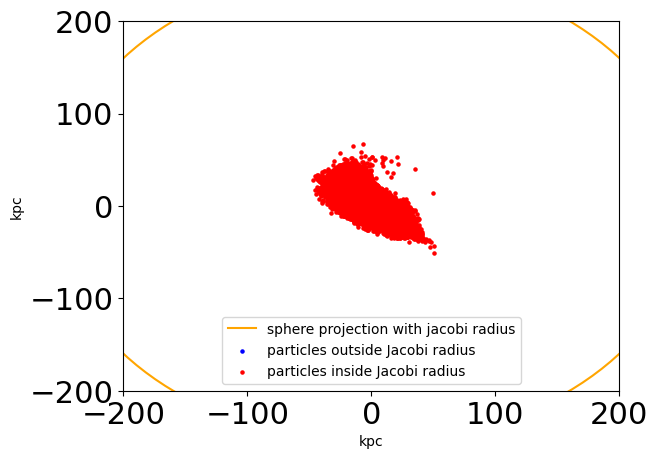

marked particle radii are [] kpc which is greater than [256.07861504] kpc


In [ ]:
MWorbit_data = np.genfromtxt('OrbitMW_0_800.txt',dtype=None,names=True,skip_header=0)
M31orbit_data = np.genfromtxt('OrbitM31_0_800.txt',dtype=None,names=True,skip_header=0)
times = M31orbit_data['t']
timenow_index = np.where(abs(times-(M31time.value/1000)) < 0.001) #because of rounding, these numbers should be at least this close
M31_xcom = M31orbit_data['x'][timenow_index]
M31_ycom = M31orbit_data['y'][timenow_index]
M31_zcom = M31orbit_data['z'][timenow_index]

#we'll check disk particles first
type_index = np.where(MWdata['type'] == 2)
xs = M31data['x'][type_index]
ys = M31data['y'][type_index]
zs = M31data['z'][type_index]

outside_index = find_outside_particles(M31_Jacobi_rad, xs,ys,zs, M31_xcom, M31_ycom, M31_zcom)
inside_index = find_inside_particles(M31_Jacobi_rad, xs,ys,zs, M31_xcom, M31_ycom, M31_zcom)

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = M31_Jacobi_rad
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.plot(x,y, c = 'orange', label = 'sphere projection with jacobi radius')
r_M31, v_M31 = get_disk_info('M31_300.txt')
plt.scatter(r_M31[:,0][outside_index], r_M31[:,2][outside_index], s = 5, c = 'blue', label = 'particles outside Jacobi radius')
plt.scatter(r_M31[:,0][inside_index], r_M31[:,2][inside_index], s = 5, c = 'red',label = 'particles inside Jacobi radius' )
plt.legend()
plt.ylim(-200,200)
plt.xlim(-200,200)
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.show()

particle_radii = np.sqrt((M31_xcom - xs[outside_index])**2 + (M31_ycom - ys[outside_index])**2 + (M31_zcom - zs[outside_index])**2)
print('marked particle radii are', particle_radii, 'kpc', 
    'which is greater than', M31_Jacobi_rad, 'kpc')

Either there is no obvious mass transfer happening yet, or our calcluation of the Jacobi radius isn't accurate anymore. Let's analyze the Hernquist profiles to see how well those still hold. 

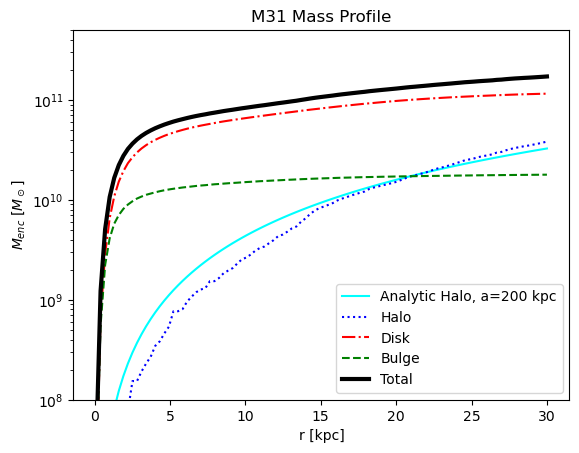

In [ ]:
M31 = MassProfile("M31",270)
MW = MassProfile("MW", 270)
def mEncPlot(galaxy, snap, plot_name, a):
    '''
    Plots the total and component-wise mass profile of a galaxy, 
    along with the analytic expectation from the Hernquist profile.

    PARAMETERS
    ----------
    galaxy : `str; 'MW', 'M31', or 'M33'`
        Name of the galaxy to read in
    snap : `int`
        Number of the snapshot to read in
    plot_name : 'str'
        Filename to save the plot under
    a : `float`
        Hernquist scale radius for analytic plot
    '''

    # read in galaxy information
    mProf = MassProfile(galaxy, snap) # mass profile

    # finding filename 
    ilbl = '000' + str(snap) # pad snapshot number
    ilbl = ilbl[-3:] # cut off leading digits so we end up 
      #with a three-digit snap number
    filename='%s_'%(galaxy) + ilbl + '.txt'
        
    M_halo_tot = ComponentMass(filename, 1) * 1e12 * u.Msun 
        # halo mass in Msun

    # radius array in kpc
    r_arr = np.linspace(0.1, 30, 100)

    # calculate mass profiles
    m_halo = mProf.massEnclosed(1, r_arr)
    m_disk = mProf.massEnclosed(2, r_arr)
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        m_bulge = mProf.massEnclosed(3, r_arr)
    m_tot = mProf.massEnclosedTotal(r_arr)

    # make plot
    fig, ax = plt.subplots()
    # lines
    ax.plot(r_arr, mProf.hernquistMass(r_arr, a, M_halo_tot), 
            c='cyan', label='Analytic Halo, a={} kpc'.format(a))
    ax.plot(r_arr, m_halo, c='b', linestyle=':', label='Halo')
    ax.plot(r_arr, m_disk, c='r', linestyle='-.', label='Disk')
    if galaxy != 'M33' : 
        # M33 doesn't have a bulge, so skip this if needed
        ax.plot(r_arr, m_bulge, c='g', linestyle='--', label='Bulge')
    ax.plot(r_arr, m_tot, c='k', linewidth=3, label='Total')
    # other formatting 
    ax.set(xlabel='r [kpc]', ylabel='$M_{enc}$ $[M_\\odot]$', 
           yscale='log', ylim=[1e8, 5e11], title=galaxy+' Mass Profile')
    ax.legend()
    # save as image
    #plt.savefig(plot_name)
#mEncPlot('MW', 270, 'MW_mass.png', 110)
mEncPlot('M31', 270, 'MW_mass.png', 200)

This indicates that the shapes of the galaxies very clearly change, as the scale factor for M31 has increased from 60 kpc to 350 kpc. Also, the analytic approximation becomes less accurate in general... 

Next steps:

1. automate this process by creating a new class called MassTransfer
2. Check the next close encounter at 5.6-5.8 Gyr to see if more mass transfer happens later. 
3. Refine the Jacobi radius calculation. Which elements of mass should we include in the $M_{sat}$ calculation, and how do we calculate the adequate enclosed mass for the dark matter component of the host galaxy?

meeting notes

1. enclosed mass, just measure how many total particles of the galaxy are within the radius in the jacobi radius calculation (see hw 5ish)
2. for KE, subtract COM velocities from the satellite galaxy
3. satellite galaxy mass... (complete satellite galaxy mass)
4. try this for dark matter instead of disk matter
5. run new energy cuts with updated kinetic energy


(array([], dtype=int64),)


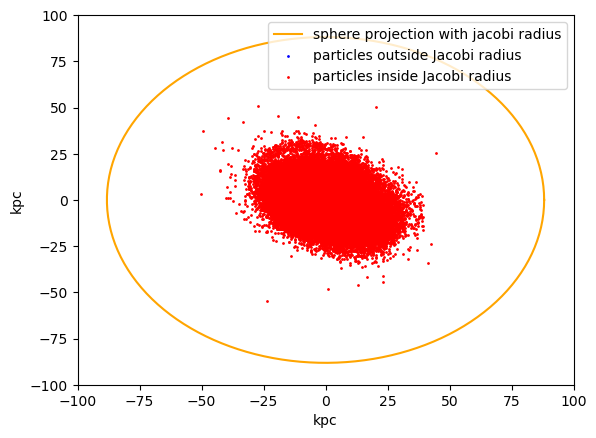

"\nparticle_radii = np.sqrt((M31_xcom - xs[outside_index])**2 + (M31_ycom - ys[outside_index])**2 + (M31_zcom - zs[outside_index])**2)\nall_particle_radii = np.sqrt((M31_xcom - xs)**2 + (M31_ycom - ys)**2 + (M31_zcom - zs)**2)\nprint('marked particle radii are', particle_radii, 'kpc', \n    'which is greater than', new_jacobi_rad, 'kpc')\n"

In [52]:
#we'll check DM particles now

DM_index = np.where(MWdata['type'] == 2)
xs = M31data['x'][DM_index]
ys = M31data['y'][DM_index]
zs = M31data['z'][DM_index]

'''
xs = M31data['x']
ys = M31data['y']
zs = M31data['z']
'''
outside_index = find_outside_particles(new_jacobi_rad, xs,ys,zs, M31_xcom, M31_ycom, M31_zcom)
inside_index = find_inside_particles(new_jacobi_rad, xs,ys,zs, M31_xcom, M31_ycom, M31_zcom)
print(outside_index)
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = new_jacobi_rad
x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.plot(x,y, c = 'orange', label = 'sphere projection with jacobi radius')
plt.scatter(r_M31[:,0][outside_index], r_M31[:,2][outside_index], s = 1, c = 'blue', label = 'particles outside Jacobi radius')
plt.scatter(r_M31[:,0][inside_index], r_M31[:,2][inside_index], s = 1, c = 'red',label = 'particles inside Jacobi radius' )
plt.legend()
plt.ylim(-100,100)
plt.xlim(-100,100)
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.show()
'''
particle_radii = np.sqrt((M31_xcom - xs[outside_index])**2 + (M31_ycom - ys[outside_index])**2 + (M31_zcom - zs[outside_index])**2)
all_particle_radii = np.sqrt((M31_xcom - xs)**2 + (M31_ycom - ys)**2 + (M31_zcom - zs)**2)
print('marked particle radii are', particle_radii, 'kpc', 
    'which is greater than', new_jacobi_rad, 'kpc')
'''

In [60]:
#let's do a calculation for pure energies of all particles to see where there might be mass transfer

M31_all_x = M31data['x']
M31_all_y = M31data['y']
M31_all_z = M31data['z']
M31_all_vx = M31data['vx']
M31_all_vy = M31data['vy']
M31_all_vz = M31data['vz']


outside_index = find_outside_particles(new_jacobi_rad, M31_all_x,M31_all_y,M31_all_z, M31_xcom, M31_ycom, M31_zcom)
inside_index = find_inside_particles(new_jacobi_rad,  M31_all_x,M31_all_y,M31_all_z, M31_xcom, M31_ycom, M31_zcom)

M31_rdisk = 5 #units of kpc, scale length of M31 disk
z_disk = M31_rdisk / 5 #we might need to change these values depending on how deformed the galaxies get

M31_halomass = ComponentMass('M31_270.txt', 1) * 10**12
M31_diskmass = ComponentMass('M31_270.txt', 2) * 10**12
M31_bulgemass = ComponentMass('M31_270.txt', 3) * 10**12

all_particle_radii = np.sqrt((M31_xcom - M31data['x'])**2 + (M31_ycom - M31data['y'])**2 + (M31_zcom - M31data['z'])**2)
KE_list = find_ke(M31data['vx'] - M31_vxcom, M31data['vy'] - M31_vycom, M31data['vz'] - M31_vzcom)

halo_potential = hernquist_potential(M31_halomass, 200, all_particle_radii)
bulge_potential = hernquist_potential(M31_bulgemass, 200, all_particle_radii)



nagai_potential = Nagai_potential(M31_diskmass, M31data['x'], M31data['y'], M31data['z'], M31_rdisk, z_disk)

tot_potential = halo_potential + bulge_potential + nagai_potential
energies = KE_list + tot_potential
pos_energy_index = np.where(energies > 0)
mass_transfer_list = M31data['m'][pos_energy_index]
tot_mass_transfer =  np.sum(mass_transfer_list) * 10**10
print(tot_mass_transfer)
#print(energies[pos_energy_index])
#print(energies)







1176404221269.9998
